In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, matplotlib as mpl
import random

import mplhep as hep

hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [2]:
import design_parameters as dp

In [3]:
print(dp.coord_thickness, dp.n_layers)

2.0500000000000003 65


In [27]:
#calculate the "hexagon root" and the "hexagoned" functions 
#(analogous to the square root and the squared functions)
def hxrt(A):
    return np.sqrt(A/(3*np.sqrt(3)/2))
def hexed(sl):
    return sl**2*3*np.sqrt(3)/2

In [5]:
hxrt(12), hxrt(30)

(2.149139863647084, 3.398088489694245)

In [6]:
3.4*np.sqrt(3)/2, 2.5*np.sqrt(2)

(2.9444863728670914, 3.5355339059327378)

In [7]:
#return a pandas.DataFrame of the cell positions.
#check for the reasonable side lengths
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union

def cell_positions(layer, boundary, sidelength=1.889, debug=False, wall_thickness=dp.wall_thickness, 
                   wall_scint_gap=dp.wall_scint_gap, stagger=True, shiftY=0, shiftX=0):
    if wall_thickness!=0:
        boundary=boundary.buffer(-wall_thickness/2)
    
    y0=sidelength/2+min(boundary.exterior.xy[1])
    
    nrows = int((max(boundary.exterior.xy[1])-min(boundary.exterior.xy[1]))/(sidelength*np.sqrt(3)/2)+3)
    
    y0=(max(boundary.exterior.xy[1])+min(boundary.exterior.xy[1]))/2-sidelength*np.sqrt(3)/2*((nrows-1)//2)
    
    
    ncol= int((max(boundary.exterior.xy[0])-min(boundary.exterior.xy[0]))/(sidelength*3/2))+3
    x0=min(boundary.exterior.xy[0])
    
    
    
    # x,y are the position of the SiPM and dimple center
    
    d={a:[] for a in "x y row col boundsx boundsy area scint_boundsx scint_boundsy scint_area".split()}
    
    if stagger: #ignore the existing shiftX and shiftY
        shiftX+=[-sidelength*3/4, 0,0, sidelength*3/4][layer%4] 
        shiftY+=[0,np.sqrt(3)/2, -np.sqrt(3)/2, 0][layer%4]
    #print(shiftX)
    phi=np.linspace(-2*np.pi/3, np.pi, 6)
    for i in range(nrows):
        for j in range(-1, ncol):
            if (i +j) %2!=0:
                continue
            x=x0+j*sidelength*3/2+shiftX
            y=y0+sidelength*np.sqrt(3)/2*i+shiftY
            
            
            hexagon=Polygon(zip(x+sidelength*np.cos(phi),y+sidelength*np.sin(phi)))
            if boundary.contains(hexagon):
                d['x'].append(x)
                d['y'].append(y)
                d['row'].append(i)
                d['col'].append(j)
                d['boundsx'].append(hexagon.exterior.xy[0])
                d['boundsy'].append(hexagon.exterior.xy[1])
                d['area'].append(hexagon.area)
                #smaller hexagon for the scintillator cell itself (ie, minus the frame or ESR wrap)
                scint_sidelength=sidelength-(wall_thickness/2+wall_scint_gap)/(np.sqrt(3)/2)
                hexagon2=Polygon(zip(x+scint_sidelength*np.cos(phi),y+scint_sidelength*np.sin(phi)))
                d['scint_boundsx'].append(hexagon2.exterior.xy[0])
                d['scint_boundsy'].append(hexagon2.exterior.xy[1])
                d['scint_area'].append(hexagon2.area)
    df=pd.DataFrame(d)
    
    if debug: print(f"layer={layer} hex area ={sum(df.area)}, boundary area={boundary.area}, ratio= {sum(df.area)/boundary.area}")
    return df
    
            

In [11]:
def print_summary_stats(df, boundary):
    hexagons=df.query("augmented==0 and cropped==0")
    tot_area=boundary.area
    hex_area=sum(hexagons.area)
    
    n_tot = len(df)
    n_hex = len(hexagons)
    print(f"total area: {tot_area:.1f} cm^2")
    print(f"area covered by regular hexagons: {hex_area:.1f} cm^2")
    print(f"(regular hexagon area)/(total area): {100*hex_area/tot_area:.1f}%")
    print(f"total cells: {n_tot}")
    print(f"# of regular hexagon cells: {n_hex}")
    print(f"(regular hexagon cells)/(total cells): {100*n_hex/n_tot:.1f}%")
    
    scint_area=sum(df.scint_area)
    scint_hex_area=sum(df.query("augmented==0 and cropped==0").scint_area)
    
    print(f"scintillator area: {scint_area} cm^2")
    print(f"dead area: {tot_area-scint_area:.1f} cm^2  ({100*(tot_area-scint_area)/scint_area:.1f}%)")
    
    
    print(f"area covered by regular hexagon scintillators: {scint_hex_area:.1f} cm^2 ({100*scint_hex_area/tot_area:.1f}% of total)")
    
    

In [271]:
#now tabulate all layers, and also create a dataframe that contains the summary variables
all_layers ={}
all_bounds={}
absorber_material=dp.absorber_material

columns=[]
columns+="layer side deadzone_frac channels reg_hexes sidelength absorber_material".split()
columns+="tot_area scint_area deadzone_area area".split()
d={a:[] for a in columns}

nsmalllayers=20

for layer in range(1,60+1):
    #holex=beampipe.holeX(layer)
    #holer=beampipe.holeR(layer)
    for side in "LR":
        
        bounds=dp.layer_boundaries(layer, side)
        #print(max(bounds.exterior.xy[1]))
        #print(bounds.exterior.xy)
        #print(min(bounds.exterior.xy[0]))
        if layer <=nsmalllayers:
            sidelength=2.16
            shiftX=sidelength*.46 if side=="L" else sidelength*.48
            shiftY=sidelength*np.sqrt(3)/4
            stagger=True
        else:
            #this yields an average deadzone area of 29.6%
#             sidelength=3.4
#             shiftX=-3.4*.45 if side=="R" else 3.4*.13
#             shiftY=-sidelength*np.sqrt(3)/2 if side=="R" else 0
            
            if side=="L":
                sidelength=2.84
                w=np.max(bounds.exterior.xy[0])-np.min(bounds.exterior.xy[0])
                shiftX=w-(w//sidelength)*sidelength+sidelength*.47
                shiftY=sidelength*np.sqrt(3)/2
            if side=="R":
                sidelength=3.1
                shiftX=-sidelength*.495  
                shiftY=sidelength*np.sqrt(3)/2*0
            stagger=False
        #print(layer,side, shiftX, shiftY)
        df_layer_side=cell_positions(layer, bounds, 
                                     sidelength=sidelength, 
                                     stagger=stagger,
                                     shiftX=shiftX,
                                     shiftY=shiftY)
        all_bounds[(layer,side)]=bounds
        all_layers[(layer, side)]=df_layer_side
        d['layer'].append(layer)
        d['side'].append(side)
        #d['holeX'].append(holex)
        #d['holeR'].append(holer)
        tot_area=bounds.area
        d['tot_area'].append(tot_area)
        scint_area=sum(df_layer_side.scint_area)
        d['scint_area'].append(scint_area)
        area=sum(df_layer_side.area)
        d['area'].append(area)
        deadzone_area=tot_area-scint_area
        d['deadzone_area'].append(deadzone_area)
        
        deadzone_frac = deadzone_area/tot_area
        d['deadzone_frac'].append(deadzone_frac)
        
        d['channels'].append(len(df_layer_side))
        d['reg_hexes'].append(len(df_layer_side))
        d['sidelength'].append(sidelength)
        d['absorber_material'].append(absorber_material[layer])
        
summary=pd.DataFrame(d)

print("total channels:", sum(summary.channels))

print(f"deadzone fraction: {100-100*sum(summary.area)/sum(summary.tot_area):.1f}%")
print(f"deadzone fraction (small-cell layers):  {100-100*sum(summary.area[:nsmalllayers])/sum(summary.tot_area[:nsmalllayers]):.1f}%")

print(f"deadzone fraction (large-cell layers):  {100-100*sum(summary.area[nsmalllayers:])/sum(summary.tot_area[nsmalllayers:]):.1f}%")
for s in "LR":
    print(f"deadzone fraction (large-cell layers, {s}):  {100-100*sum(summary.area[nsmalllayers:][summary.side==s])/sum(summary.tot_area[nsmalllayers:][summary.side==s]):.1f}%")
      


# print(f"deadzone fraction: {100-100*sum(summary.scint_area)/sum(summary.tot_area):.1f}%"+
#       f" ({100*sum(summary.area-summary.scint_area)/sum(summary.tot_area):.1f}% from intercell walls)")
# print(f"deadzone fraction (small-cell layers):  {100-100*sum(summary.scint_area[:nsmalllayers])/sum(summary.tot_area[:nsmalllayers]):.1f}%" +
#       f" ({100*sum(summary.area[:nsmalllayers]-summary.scint_area[:nsmalllayers])/sum(summary.tot_area[:nsmalllayers]):.1f}% from intercell walls)")
# print(f"deadzone fraction (large-cell layers):  {100-100*sum(summary.scint_area[nsmalllayers:])/sum(summary.tot_area[nsmalllayers:]):.1f}%" +
#       f" ({100*sum(summary.area[nsmalllayers:]-summary.scint_area[nsmalllayers:])/sum(summary.tot_area[nsmalllayers:]):.1f}% from intercell walls)")
# for s in "LR":
#     print(f"deadzone fraction (large-cell layers, {s}):  {100-100*sum(summary.scint_area[nsmalllayers:][summary.side==s])/sum(summary.tot_area[nsmalllayers:][summary.side==s]):.1f}%" +
#       f" ({100*sum(summary.area[nsmalllayers:][summary.side==s]-summary.scint_area[nsmalllayers:][summary.side==s])/sum(summary.tot_area[nsmalllayers:][summary.side==s]):.1f}% from intercell walls)")


total channels: 7077
deadzone fraction: 23.5%
deadzone fraction (small-cell layers):  25.5%
deadzone fraction (large-cell layers):  23.1%
deadzone fraction (large-cell layers, L):  22.4%
deadzone fraction (large-cell layers, R):  23.5%


In [272]:
for i in range(8, 18):
    sl= (2*29.645-.4)/(i*np.sqrt(3))
    print(i,sl, hexed(sl))

8 4.250019669072133 46.928185933435856
9 3.7777952613974515 37.07906049061598
10 3.4000157352577065 30.03403899739895
11 3.090923395688824 24.821519832561115
12 2.8333464460480884 20.85697152597149
13 2.615396719429005 17.77162070852009
14 2.428582668041219 15.32348928438722
15 2.266677156838471 13.34846177662176
16 2.1250098345360664 11.732046483358964
17 2.0000092560339446 10.392401037162266


In [283]:
hexed(3.1), hexed(2.84), hexed(2.16)

(24.96751239110537, 20.955043490291303, 12.12158437169003)

In [280]:
def draw_layer(layer, R_readout=0.4, fillDimple=True, color=None, shade_deadzone=True, linewidth=None):
    phi = np.linspace(-np.pi, np.pi, 7)
    dx=sidelength*np.cos(phi)
    dy=sidelength*np.sin(phi)
    if color == None:
        color='krbg'[layer%4] 
    
    for side in "LR":
        boundaries=all_bounds[(layer,side)]
        #print(boundaries)
        
        plt.plot(*boundaries.exterior.xy, linestyle='-', color=color, linewidth=linewidth)
        
        #draw the deadzone
        df=all_layers[(layer, side)]
        dz=boundaries
        for j in range(len(df)):
            dz-=Polygon(zip(df.boundsx[j],df.boundsy[j])).buffer(.001)
        for tb in -1,1:
            #split it into two parts, so that there are no holes
            dzhalf=dz-Polygon(((-100,0),(100,0),(100,-100*tb),(-100, -100*tb),(-100, 0)))
            if shade_deadzone:
                plt.gca().add_patch(mpl.patches.Polygon(list(zip(*dzhalf.exterior.xy)),color=color,alpha=0.2,
                       zorder=-1))
        
        #plt.gca().add_patch(mpl.patches.Polygon(list(zip(*boundaries.exterior.xy)), linestyle='-', color=color,alpha=0.5,
        #                   zorder=-1))
        for i in range(len(df)):
            plt.plot(df.boundsx[i], df.boundsy[i], color=color, linewidth=linewidth)
            
            plt.gca().add_patch(mpl.patches.Circle((df.x[i], df.y[i]), R_readout, color=color,
                                                      linestyle='' if fillDimple else '-',
                                                    fill=fillDimple, linewidth=linewidth))

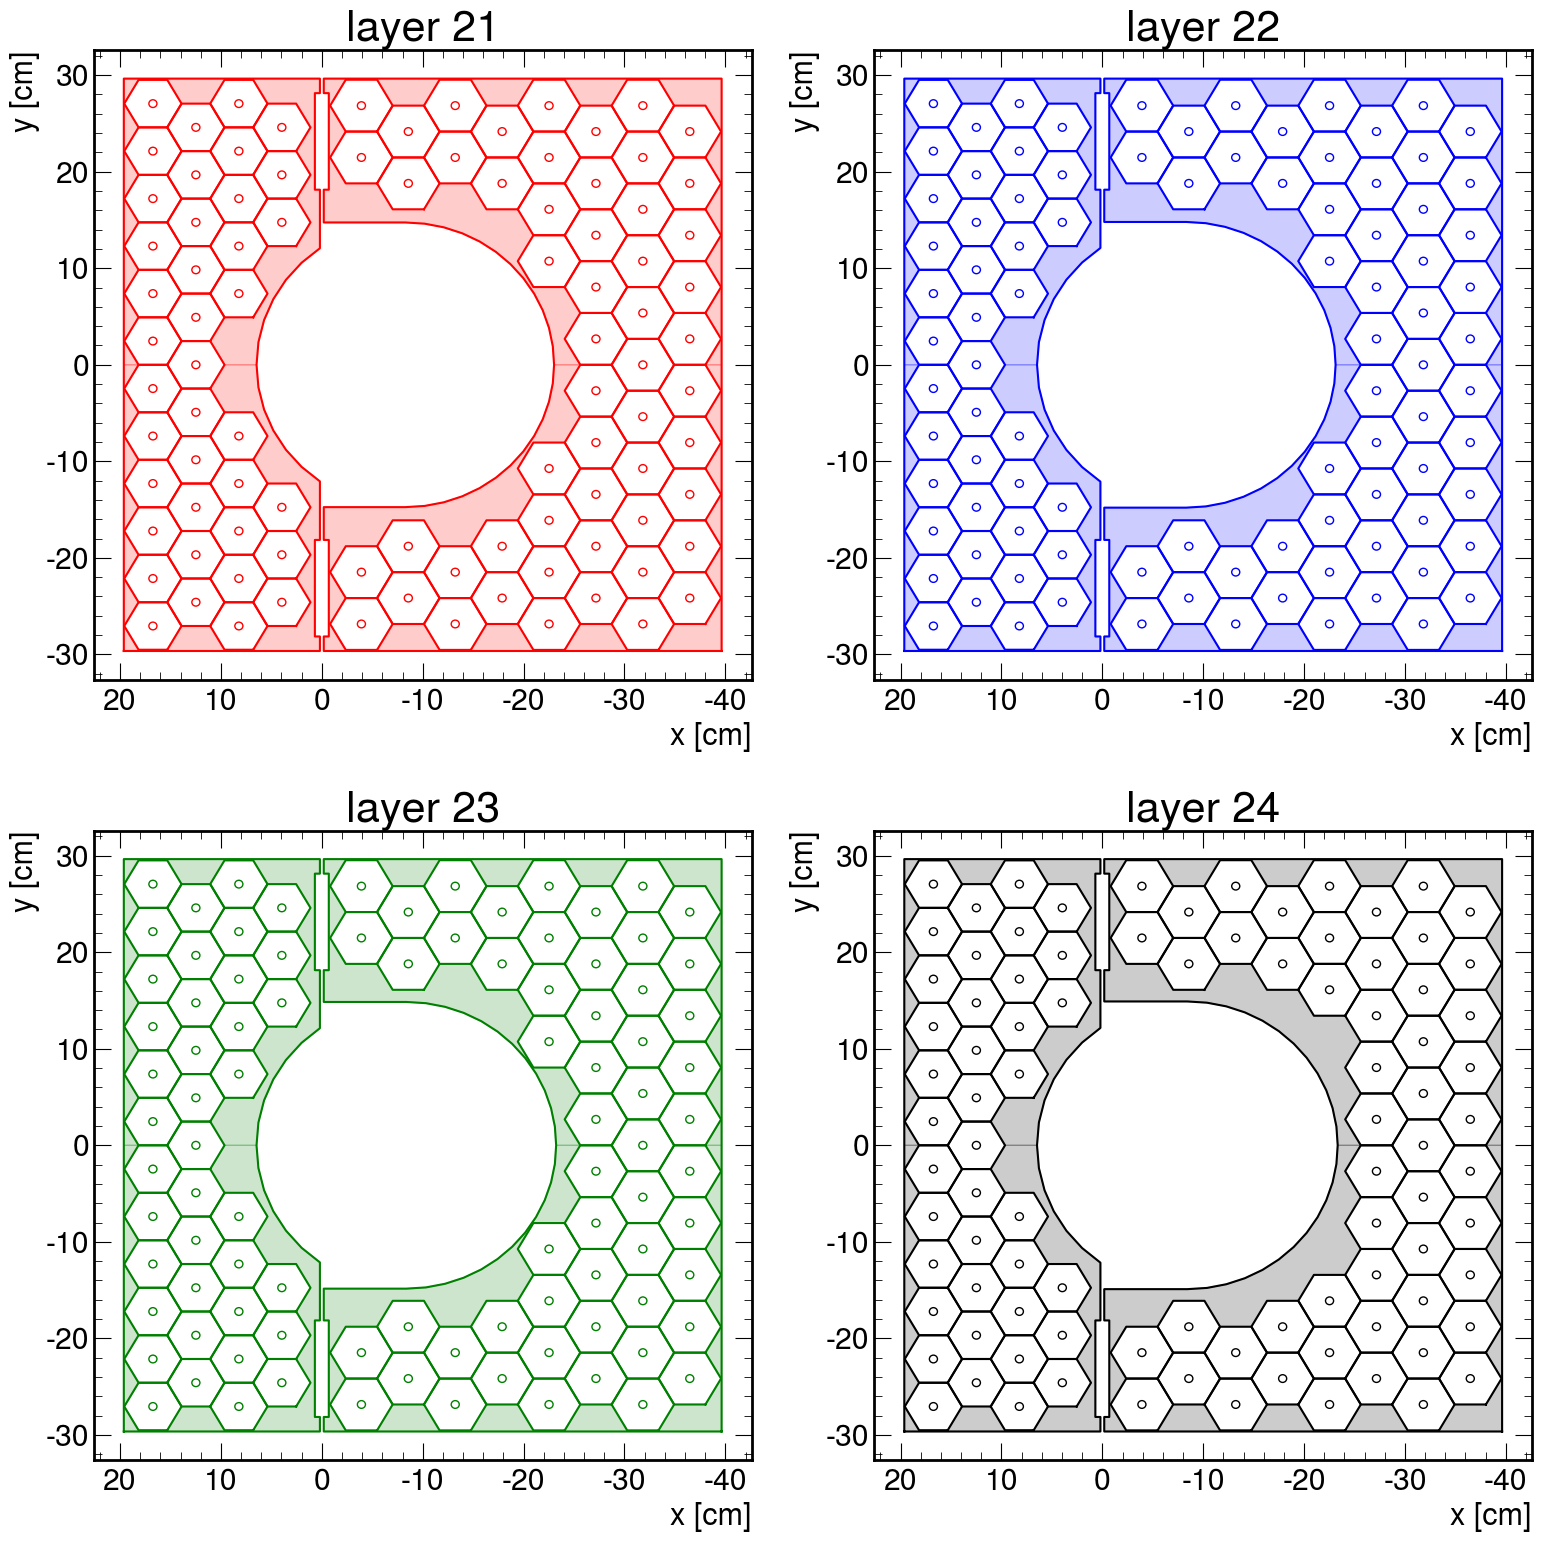

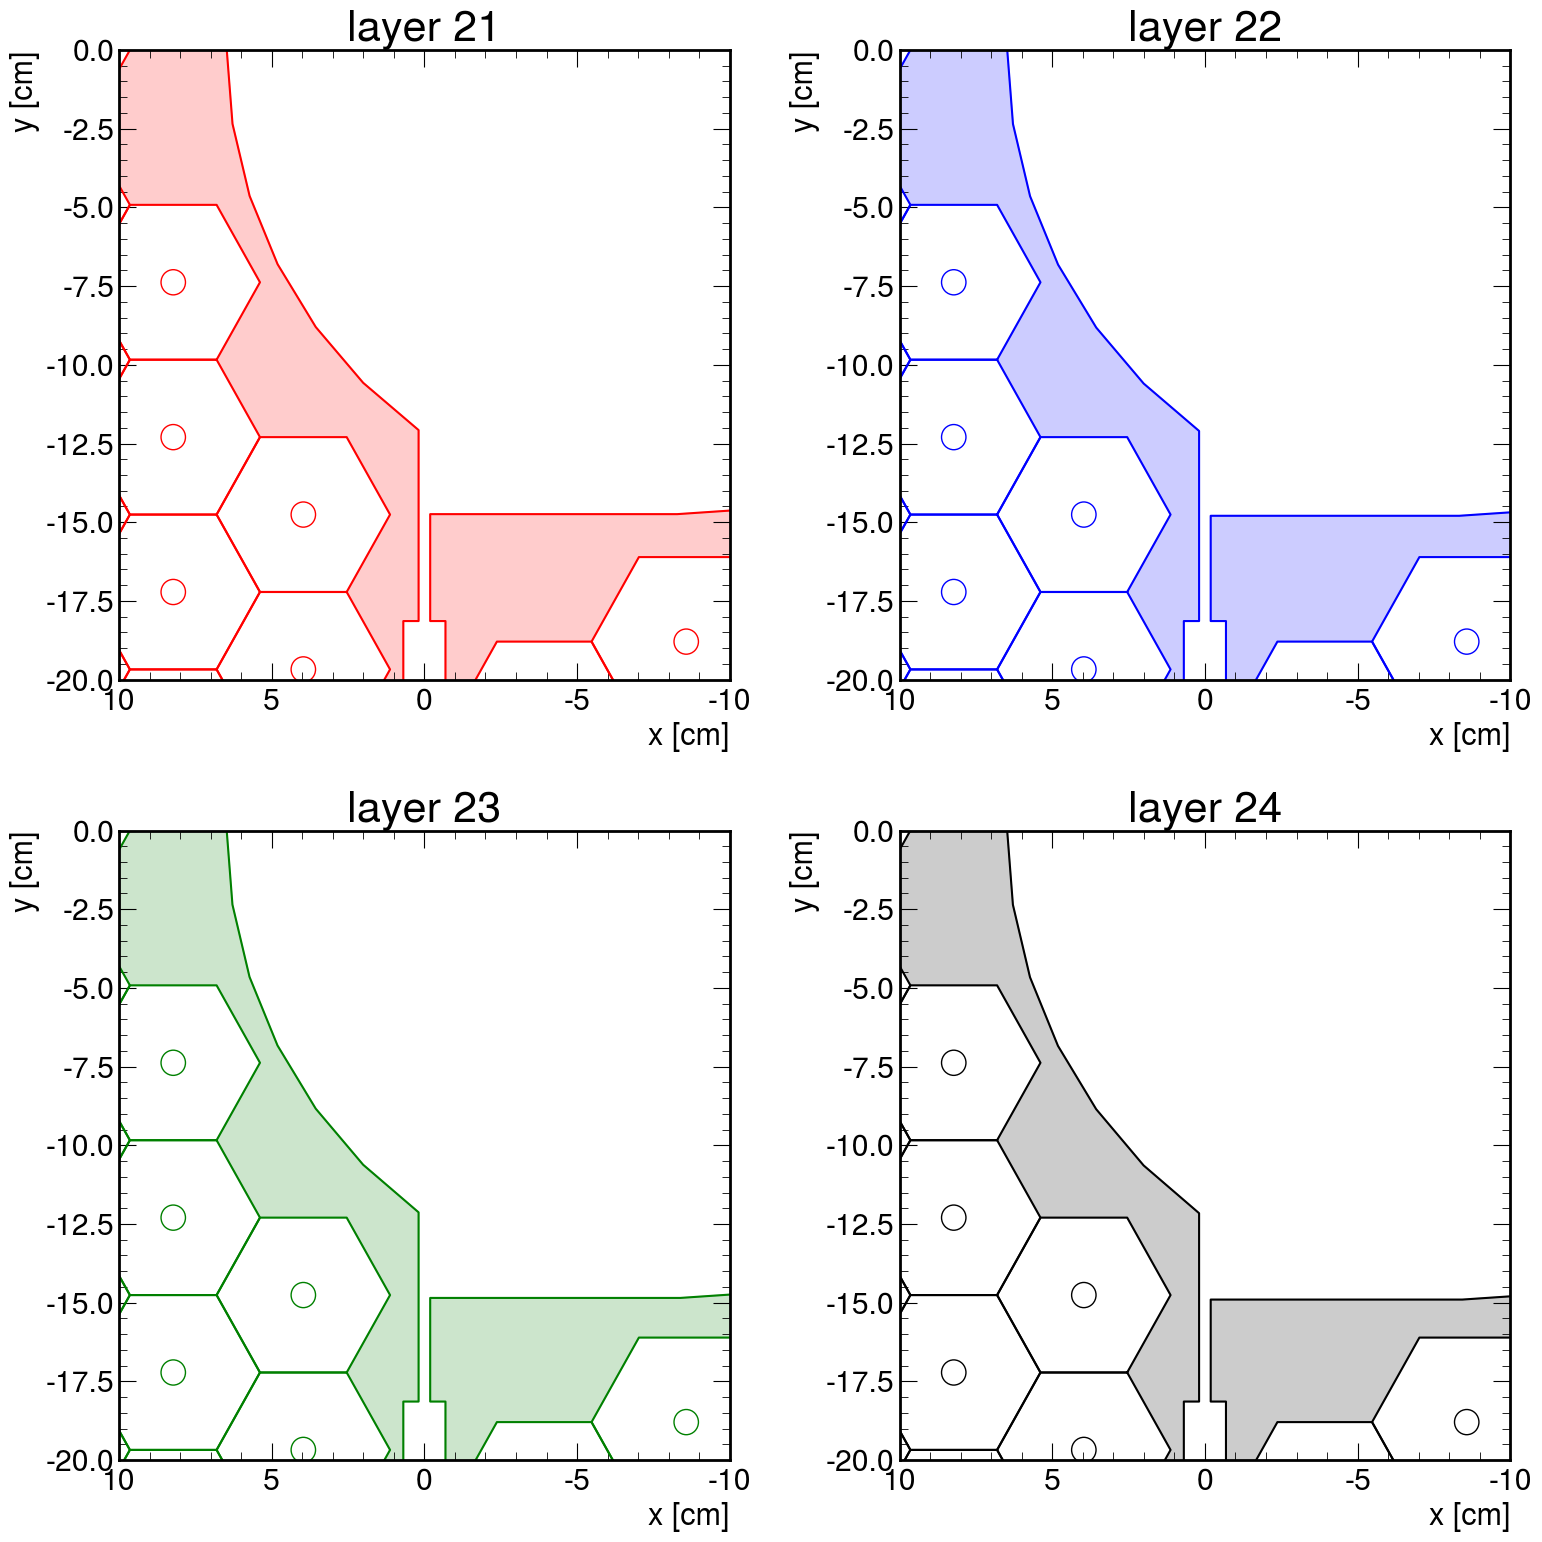

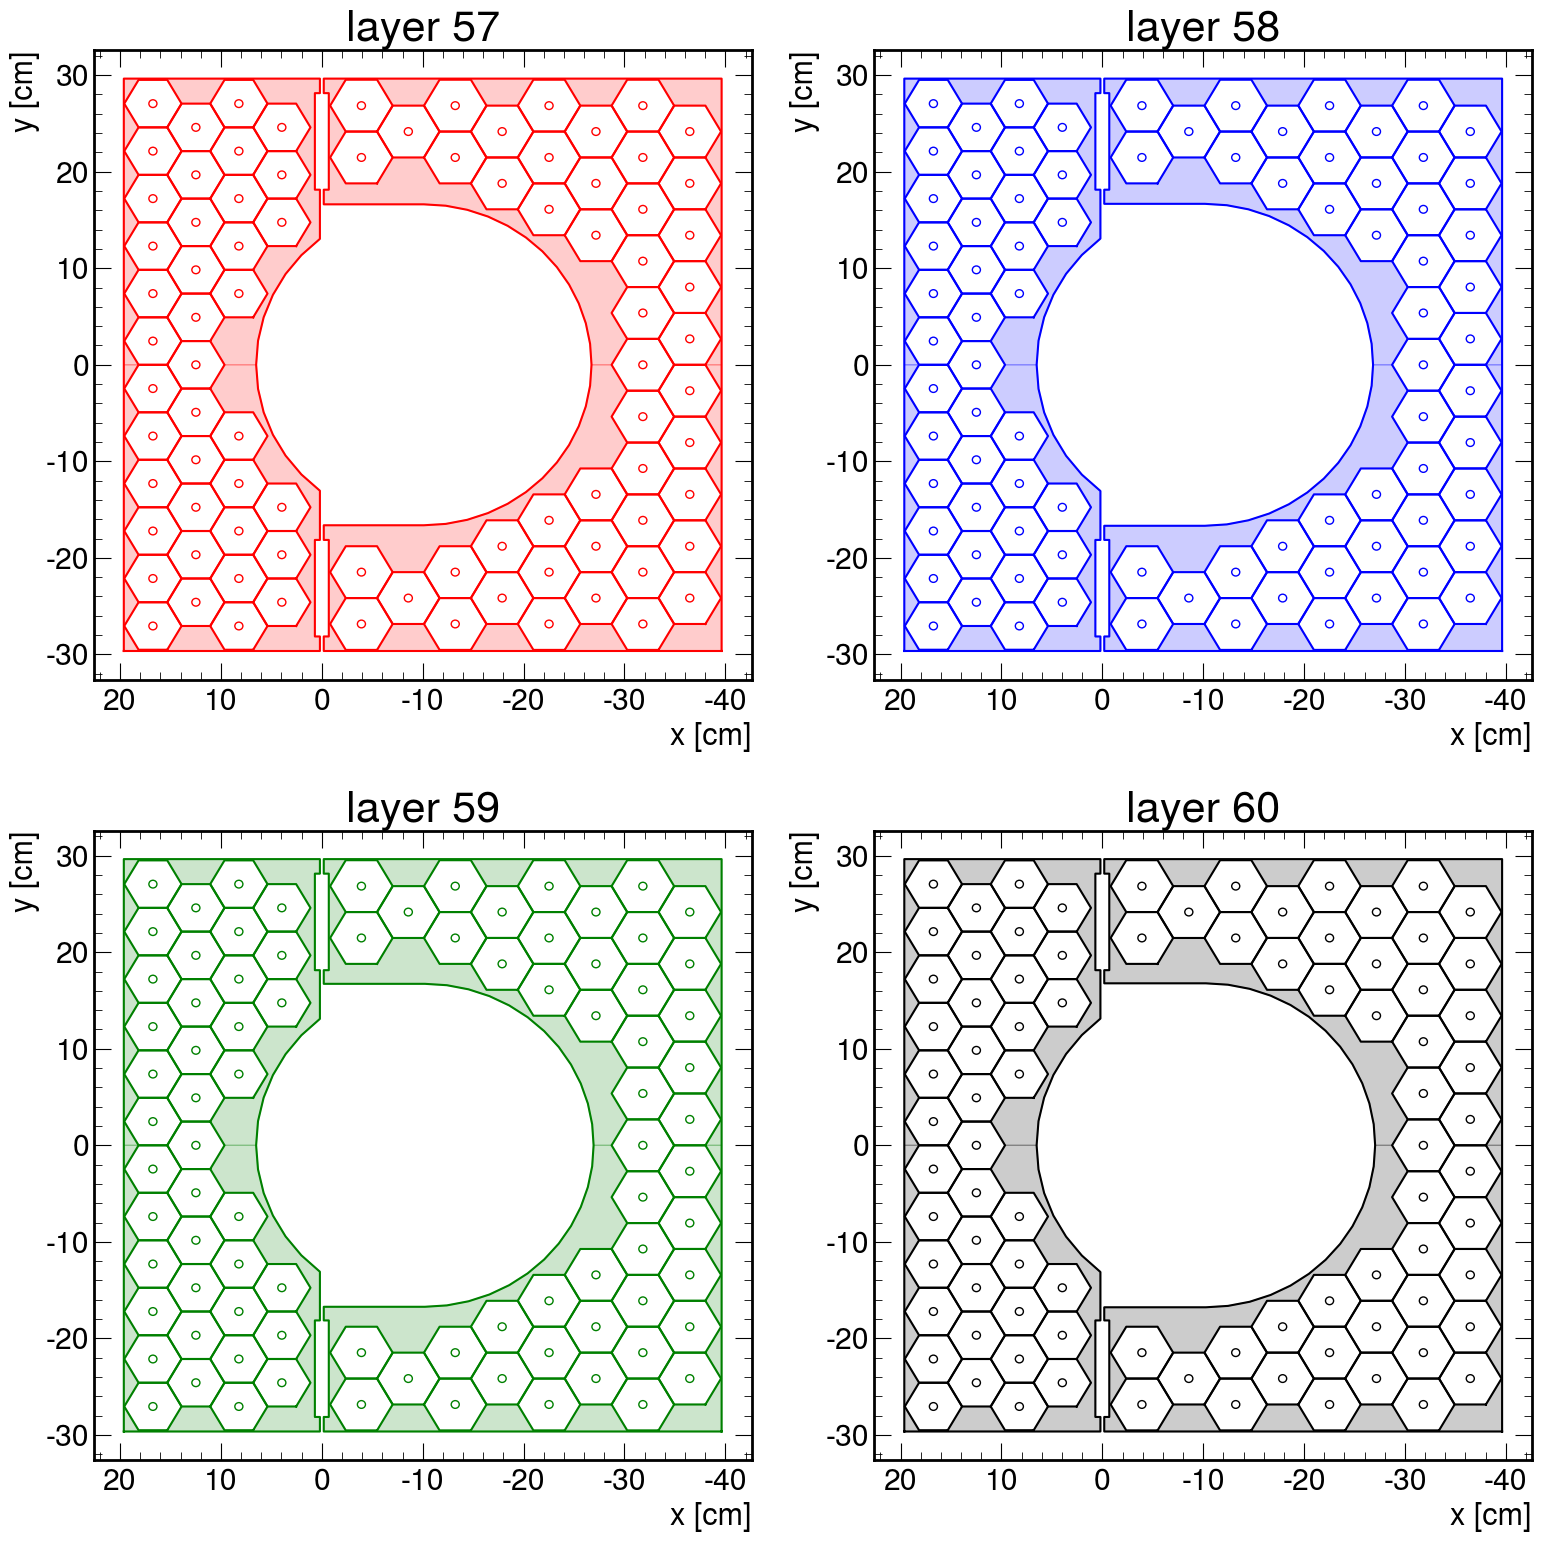

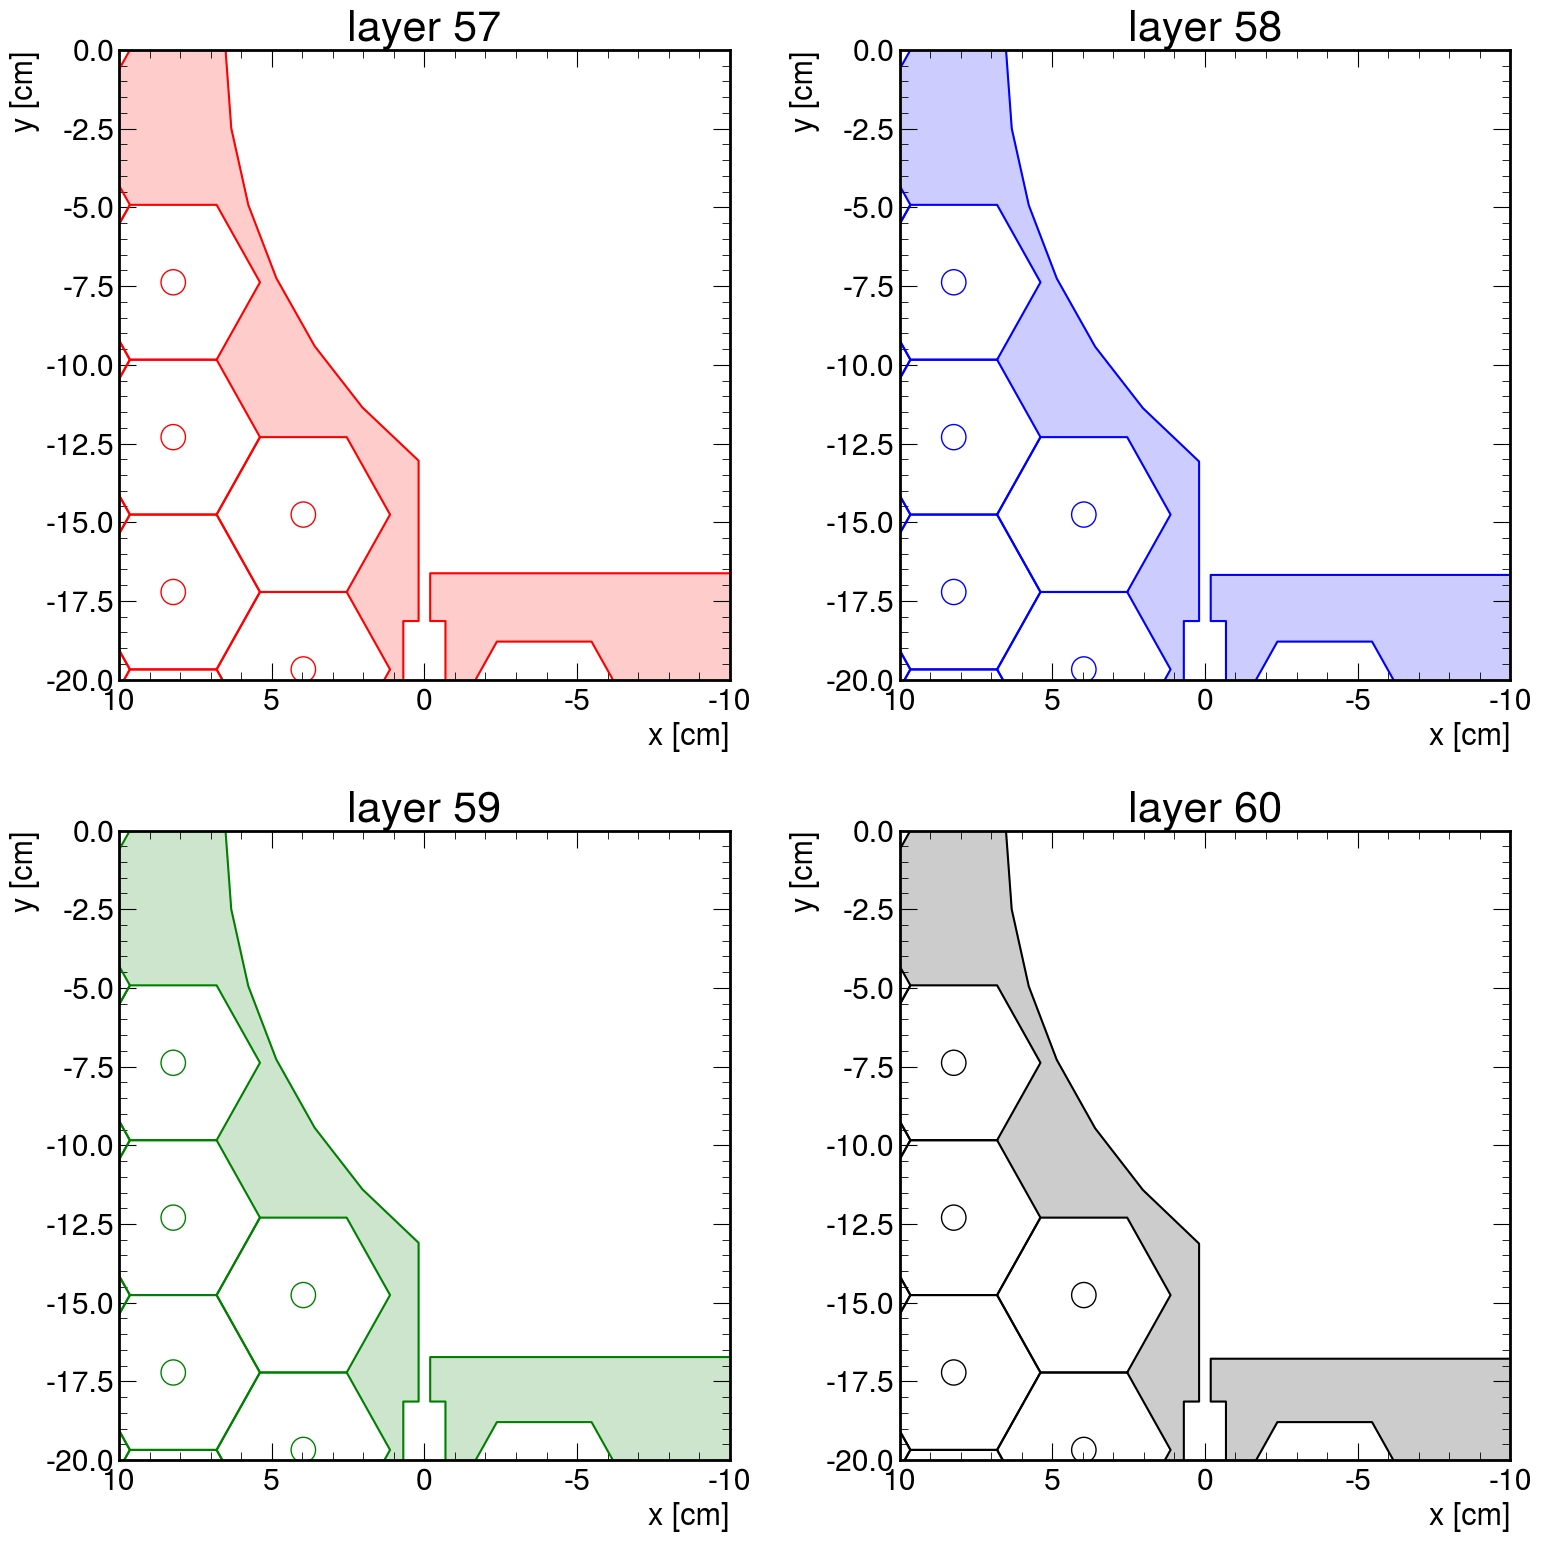

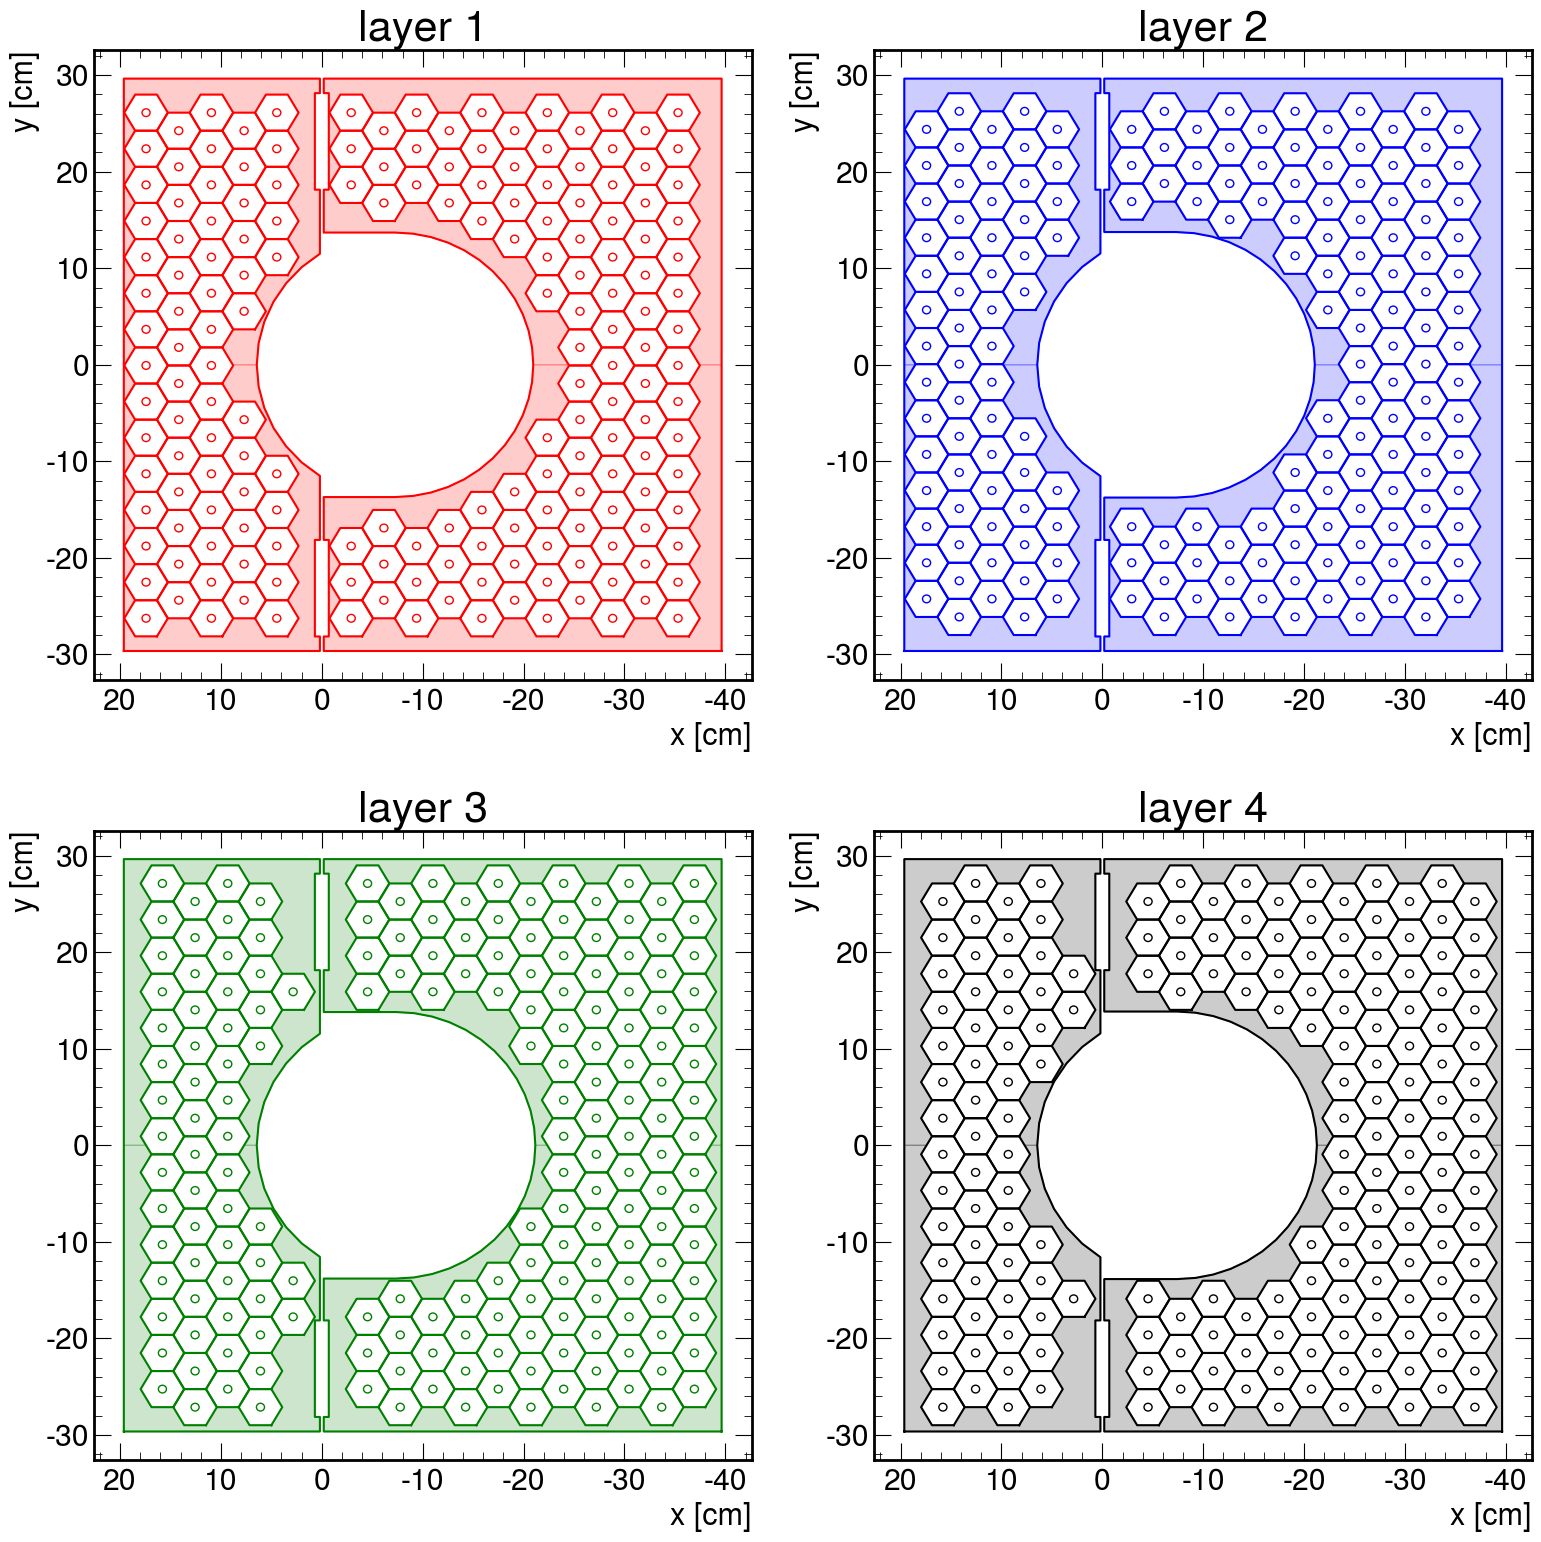

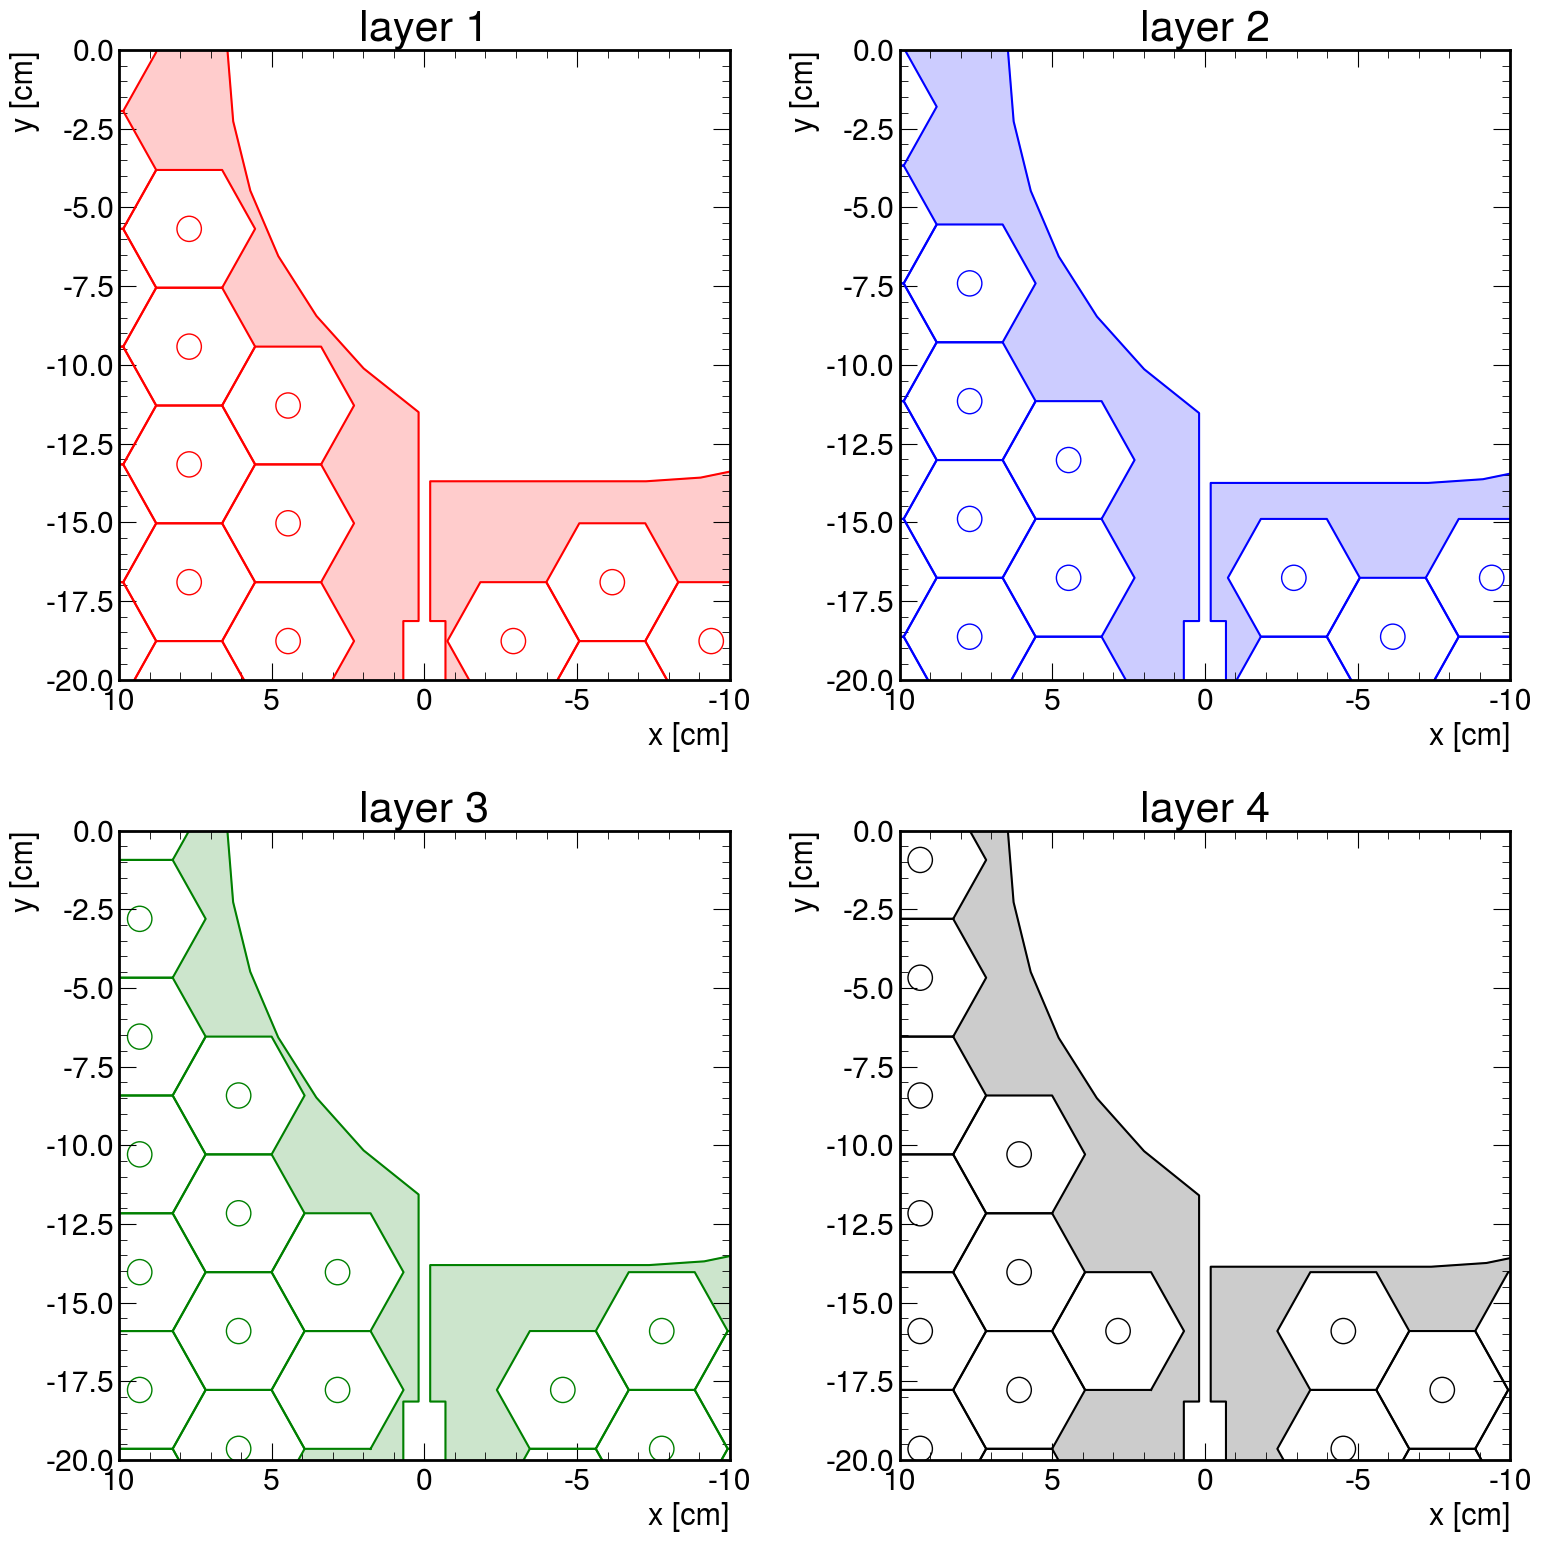

In [281]:
for layer_offset in 21, 57, 1:
    for zoom in False, True:
        arg=dict(fillDimple=False)
        
        fig,axs=plt.subplots(2,2, figsize=(16,16))
        for i in range(4):

            plt.sca(axs[i//2][i%2])
            plt.title(f"layer {i+layer_offset}")
            draw_layer(i+layer_offset, **arg)
            plt.gca().invert_xaxis()
            #plt.sca(axs[1][1])
            #plt.title(f"layers 0-2")
            #draw_layer(i, **arg)
    #     axs[1][1].invert_xaxis()
        for row in axs:
            for ax in row:
                ax.set_xlabel("x [cm]", fontsize=22)
                ax.set_ylabel("y [cm]", fontsize=22)
                if zoom:
                    ax.set_xlim(-10, 10)
                    ax.set_ylim(-20, 0)
                    ax.invert_xaxis()
        plt.tight_layout()
        plt.savefig(f"Layers_{layer_offset}-{layer_offset+3}{'_zoom' if zoom else ''}.pdf")
        plt.show()

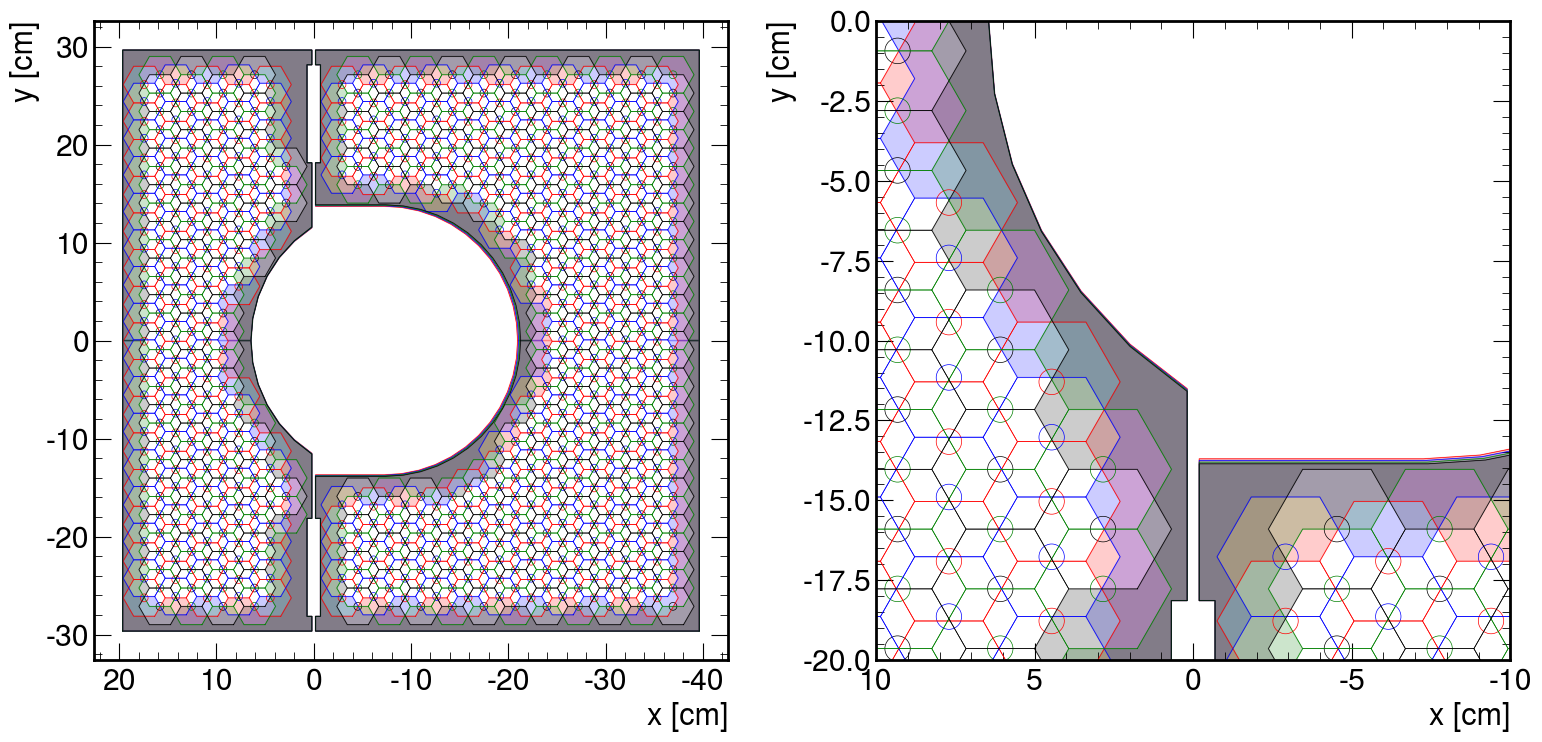

In [282]:
layer_offset= 1

fig,axs=plt.subplots(1,2, figsize=(16,8))
for zoom in False, True:
    arg=dict(fillDimple=False, shade_deadzone=True, linewidth=0.5)
    plt.sca(axs[1*zoom])
    for i in range(4):
        draw_layer(i+layer_offset, **arg)
        
        
    plt.xlabel("x [cm]", fontsize=22)
    plt.ylabel("y [cm]", fontsize=22)
    if zoom:
        plt.xlim(-10, 10)
        plt.ylim(-20, 0)
    
#     boundaries-
#                            zorder=-1))
#         df = all_layers[(layer, side)]
#         for i in range(len(df)):
#             plt.plot(df.boundsx[i], df.boundsy[i], color=color, linewidth=linewidth)
#             if shade_deadzone:
#                 plt.gca().add_patch(mpl.patches.Polygon(list(zip(df.boundsx[i], df.boundsy[i])
    plt.gca().invert_xaxis()
plt.tight_layout()
plt.savefig(f"Layers_{layer_offset}-{layer_offset+3}_combined.pdf")
plt.show()

In [290]:
import os
#help(os)
if not os.path.exists("insert_layout"):
    os.mkdir("insert_layout")
for i in range(1,60+1):
    for side in "LR":
        all_layers[(i, side)].drop(columns="boundsx boundsy scint_boundsx scint_boundsy scint_area".split())\
                .to_csv(f"insert_layout/SiPM_positions_{i}{side}.csv", float_format='%.3f')
        bounds=all_bounds[(i,side)]
        pd.DataFrame({"x":bounds.exterior.xy[0],"y":bounds.exterior.xy[1]})\
                .to_csv(f"insert_layout/PCB_edges_{i}{side}.csv", float_format='%.3f')

In [292]:
print("cat insert_layout/SiPM_positions_60L.csv")
!cat insert_layout/SiPM_positions_60L.csv
print("\ncat insert_layout/PCB_edges_60L.csv")
!cat insert_layout/PCB_edges_60L.csv 

cat insert_layout/SiPM_positions_60L.csv
,x,y,row,col,area
0,8.225,-27.055,1,1,20.955
1,16.745,-27.055,1,3,20.955
2,3.965,-24.595,2,0,20.955
3,12.485,-24.595,2,2,20.955
4,8.225,-22.136,3,1,20.955
5,16.745,-22.136,3,3,20.955
6,3.965,-19.676,4,0,20.955
7,12.485,-19.676,4,2,20.955
8,8.225,-17.217,5,1,20.955
9,16.745,-17.217,5,3,20.955
10,3.965,-14.757,6,0,20.955
11,12.485,-14.757,6,2,20.955
12,8.225,-12.298,7,1,20.955
13,16.745,-12.298,7,3,20.955
14,12.485,-9.838,8,2,20.955
15,8.225,-7.379,9,1,20.955
16,16.745,-7.379,9,3,20.955
17,12.485,-4.919,10,2,20.955
18,16.745,-2.460,11,3,20.955
19,12.485,0.000,12,2,20.955
20,16.745,2.460,13,3,20.955
21,12.485,4.919,14,2,20.955
22,8.225,7.379,15,1,20.955
23,16.745,7.379,15,3,20.955
24,12.485,9.838,16,2,20.955
25,8.225,12.298,17,1,20.955
26,16.745,12.298,17,3,20.955
27,3.965,14.757,18,0,20.955
28,12.485,14.757,18,2,20.955
29,8.225,17.217,19,1,20.955
30,16.745,17.217,19,3,20.955
31,3.965,19.676,20,0,20.955
32,12.485,19.676,20,2,20.955
33,8.225,22.136,